In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import pingouin as pg
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Mission n° 3

### Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?
### sexe= qualitative , catégorie produit= qualitative

In [203]:
# Télécharger les tables avec et sans outliers atypiques ('c_1609', 'c_4958', 'c_6714', 'c_3454')
data_final1 = pd.read_csv('data_final1.csv') #(avec outliers)
data_final2 = pd.read_csv('data_final2.csv') #(sans outliers)

In [204]:
data_final1.head()

,id_prod,session_id,client_id,date,datetime,heure,annee,mois,jour,jour_semaine,price,categ,categ_object,sex,birth,sex_binaire,age,mois_object,tranche_age
0,0_1483,s_18746,c_4450,2021-04-10 18:37:28,2021-04-10 00:00:00,18,2021,4,10,samedi,4.99,0,categ0,f,1977,0,44,avril,30-50 ans
1,2_226,s_159142,c_277,2022-02-03 01:55:53,2022-02-03 00:00:00,1,2022,2,3,jeudi,65.75,2,categ2,f,2000,0,22,février,17-30 ans
2,1_374,s_94290,c_4270,2021-09-23 15:13:46,2021-09-23 00:00:00,15,2021,9,23,jeudi,10.71,1,categ1,f,1979,0,42,septembre,30-50 ans
3,0_2186,s_105936,c_4597,2021-10-17 03:27:18,2021-10-17 00:00:00,3,2021,10,17,dimanche,4.20,0,categ0,m,1963,1,58,octobre,50-93ans
4,0_1351,s_63642,c_1242,2021-07-17 20:34:25,2021-07-17 00:00:00,20,2021,7,17,samedi,8.99,0,categ0,f,1980,0,41,juillet,30-50 ans


In [205]:
# Le tableau contingence 
objects1 = data_final1[['sex', 'categ_object']]
objects2 = pd.crosstab(objects1['sex'], objects1['categ_object'], margins=True)
objects2

categ_object,categ0,categ1,categ2,All
sex,,,,
f,103786,55469,8260,167515
m,105640,54266,9292,169198
All,209426,109735,17552,336713


Text(0.5, 1.0, 'La heatmap du tableau de contingence')

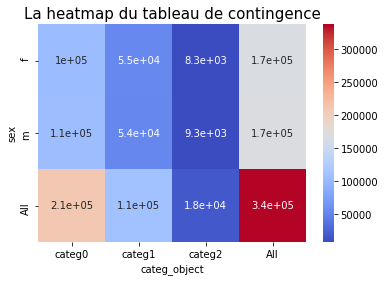

In [206]:
#La heatmap du tableau contingence
sns.heatmap(objects2,annot=True, cmap='coolwarm')
plt.title('La heatmap du tableau de contingence', size=15)

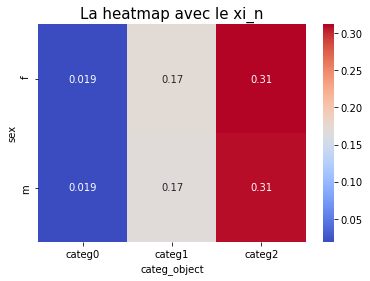

81.86933350990711


In [207]:
#Le xi_n est de 81.86933350990711 (plus ξn est grand, moins l'hypothèse d'indépendance est valide.)

tx = objects2.loc[:,["All"]]# colonne ALL
ty = objects2.loc[["All"],:] # ligne ALL        
n = len(data_final1)# nbre lignes data_final1
indep = tx.dot(ty) / n  # produits scalaire entre tx et ty /n 
c = objects2.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep  #contient tous les ξij pour chaque case du tableau. On peut ensuite calculer les contributions (que nous avons définies plus haut) en divisant chaque ξij par ξn (placé dans la variable xi_n  ). On fait ceci en ligne 11 par  measure/xi_n  
                              #. On obtient ainsi pour chaque case une valeur comprise entre 0 et 1
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=True, cmap='coolwarm')
plt.title('La heatmap avec le xi_n', size=15)
plt.show()
print(xi_n)

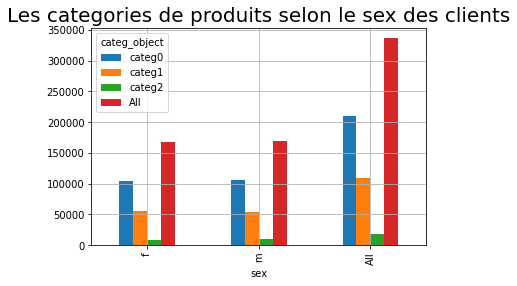

In [208]:
objects2.plot.bar()
plt.title("Les categories de produits selon le sex des clients", size=20)
plt.grid(True)

In [209]:
#Teste si deux variables catégorielles sont liées ou indépendantes

#H0: les deux échantillons sont indépendants.
#H1: il existe une dépendance entre les échantillons.

from scipy.stats import chi2_contingency
table = objects2
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probablement independant')
else:
    print('Probablement dépendant')

print("Conclusion: Il y a une corrélation entre le sex et la catégorie des produits achetés")

stat=81.869, p=0.000
Probablement dépendant
Conclusion: Il y a une corrélation entre le sex et la catégorie des produits achetés


# Y a-t-il une corrélation entre l'âge des clients et :
### Le montant total des achats
### quantitative et quantitative

In [210]:
df = data_final1.groupby('age').sum()[['price']].reset_index().rename(columns={'price':'montant_total_des_achats'})
df.sort_values(by='montant_total_des_achats', ascending=False).head()

,age,montant_total_des_achats
24,41,272355.44
0,17,240669.91
5,22,212047.61
25,42,189860.28
26,43,159271.34


Text(0.5, 3000, "Relation entre montant_total_des_achats en fonction de l'age des clients")

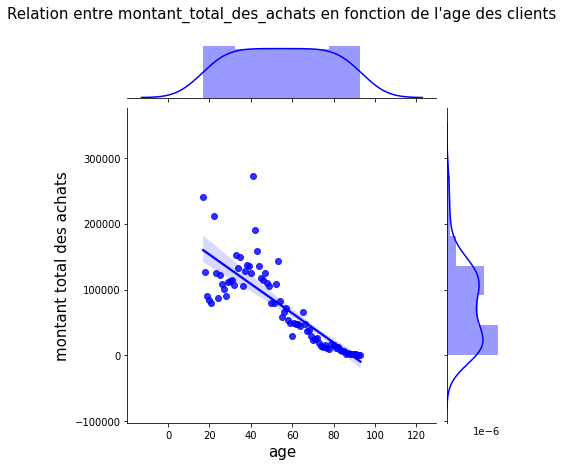

In [211]:
# Relation entre montant_total_des_achats en fonction de l'age des clients

sns.jointplot(x='age', y='montant_total_des_achats',color='blue', data= df, kind='reg')
plt.ylabel('montant total des achats', size=15)
plt.xlabel('age', size=15)
plt.title("Relation entre montant_total_des_achats en fonction de l'age des clients", y=3000, pad= 90, size=15)


In [212]:
# Coefficient de corrélation ( force de la relation et le sens )
#Les coefficients de corrélation entre 0,10 et 0,29 représentent une petite association, 
#les coefficients entre 0,30 et 0,49 représentent une association moyenne et les coefficients de 0,50 et
#plus représentent une grande association ou relation.(Cohen)
df.corr()

,age,montant_total_des_achats
age,1.000000,-0.820558
montant_total_des_achats,-0.820558,1.000000


In [213]:
print(df['age'].corr(df['montant_total_des_achats'], method='kendall'))
print(df['age'].corr(df['montant_total_des_achats'], method='spearman'))

-0.7252221462747778
-0.8753877701246121


In [214]:
#R carré ( Qualité prédictive d'un régression linéaire)
#0,67% de varation est expliqué par le modèle 
(-0.8205582386463024)**2

0.6733158230103221

In [215]:
# Methode des moindres carrés 
model = smf.ols('montant_total_des_achats~age', data=df).fit()
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     montant_total_des_achats   R-squared:                       0.673
Model:                                  OLS   Adj. R-squared:                  0.669
Method:                       Least Squares   F-statistic:                     154.6
Date:                      Wed, 23 Sep 2020   Prob (F-statistic):           6.70e-20
Time:                              21:24:10   Log-Likelihood:                -913.73
No. Observations:                        77   AIC:                             1831.
Df Residuals:                            75   BIC:                             1836.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [216]:
# y= ax+b
pred_montant =  -2226.1989*16 + 1.977e+05
pred_montant

162080.8176

In [217]:
# Prédiction pour client 16 ans 
a_prevoir = pd.DataFrame({'age':[16]})
price_prev = model.predict(a_prevoir)
price_prev

0    162101.986866
dtype: float64

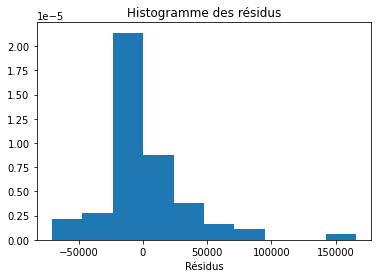

In [218]:
# Histogramme des résidus
df['residu_s'] = model.resid
plt.hist(df['residu_s'], density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
plt.show()

In [219]:
#Teste si un échantillon de données(residu) a une distribution gaussienne avec shapiro
#H0: l'échantillon a une distribution gaussienne.
#H1: l'échantillon n'a pas de distribution gaussienne.

from scipy.stats import shapiro
import scipy.stats
data = df['residu_s'].values
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("la distribution age est probalemement gaussien")
else:
    print("la distribution age n'est probalemement pas gaussien")

stat=0.864, p=0.000
la distribution age n'est probalemement pas gaussien


In [220]:
print("Conclusion: Il y une corrélation négative  entre l'age et le montant total des achats")

Conclusion: Il y une corrélation négative  entre l'age et le montant total des achats


# Y a-t-il une corrélation entre l'âge des clients et :

# La fréquence d’achat (ie. nombre d'achats par mois par exemple) ;
    quantitative et quantitative

In [221]:
#groupby aggrégation count et group by aggrégation mean 
df4= data_final1[['client_id', 'mois', 'price']].groupby(['client_id', 'mois']).count().reset_index()
df4= df4[['client_id', 'price']].groupby('client_id').mean().reset_index()
df4

,client_id,price
0,c_1,2.500000
1,c_10,3.500000
2,c_100,2.000000
3,c_1000,4.666667
4,c_1001,6.444444
...,...,...
8595,c_995,1.600000
8596,c_996,3.818182
8597,c_997,2.555556
8598,c_998,3.500000


In [222]:
#merge entre df4 et cliend_id, age du dataframe final
df5= df4.merge(data_final1[['client_id', 'age']].sort_values(['client_id', 'age']).drop_duplicates('client_id',keep='first'), on= 'client_id' , how='left')
df5

,client_id,price,age
0,c_1,2.500000,66
1,c_10,3.500000,65
2,c_100,2.000000,29
3,c_1000,4.666667,55
4,c_1001,6.444444,39
...,...,...,...
8595,c_995,1.600000,66
8596,c_996,3.818182,51
8597,c_997,2.555556,27
8598,c_998,3.500000,20


In [223]:
# Groupby par age aggrégation mean 

df6 = df5[['price', 'age']].groupby('age').mean().reset_index()

df7= df6.rename(columns={'price':'fréquence_achat'})
df7 = df7.sort_values(by='fréquence_achat', ascending=False)
df7

,age,fréquence_achat
24,41,11.436550
20,37,6.479533
21,38,6.385219
19,36,6.129437
26,43,6.114549
...,...,...
10,27,2.579682
12,29,2.546029
1,18,2.521989
2,19,2.510855


Text(0.5, 3000, "Relation entre la fréquence achats et l'ages des clients")

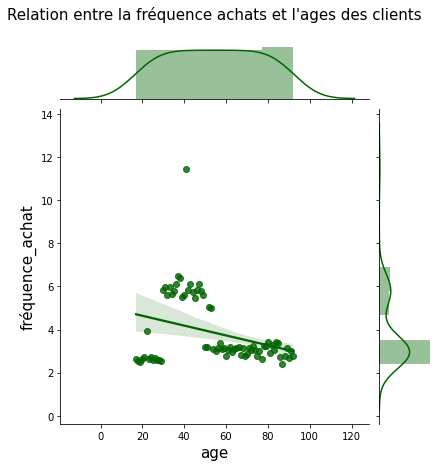

In [224]:
#Relation entre la fréquence achats et l'ages des clients
sns.jointplot(x='age', y='fréquence_achat',color='darkgreen', data= df7, kind='reg')
plt.xlabel('age', size=15)
plt.ylabel('fréquence_achat', size=15)
plt.title("Relation entre la fréquence achats et l'ages des clients", y=3000, pad= 90, size=15)


In [225]:
# Coefficient corrélation 
df7.corr()

,age,fréquence_achat
age,1.000000,-0.319333
fréquence_achat,-0.319333,1.000000


In [226]:
#les coefficients corrélations ( kendall et spearman )

print(df7['age'].corr(df7['fréquence_achat'], method='kendall'))
print(df7['age'].corr(df7['fréquence_achat'], method='spearman'))

-0.13333333333333336
-0.09520164046479836


In [227]:
# R carré
(-0.319332973440672)**2

0.10197354792646095

In [228]:
#  Teste pearson si deux échantillons ont une relation linéaire.
#H0: les deux échantillons sont indépendants.
#H1: il existe une dépendance entre les échantillons.

from scipy.stats import pearsonr
data1 = df7['age'].values
data2 = df7['fréquence_achat'].values
stat, p = pearsonr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('probablement indépendant ')
else:

    print('Probablement dépendant ')

stat=-0.319, p=0.005
Probablement dépendant 


In [229]:
#Teste si un échantillon de données(age) a une distribution gaussienne avec shapiro
#H0: l'échantillon a une distribution gaussienne.
#H1: l'échantillon n'a pas de distribution gaussienne.

from scipy.stats import shapiro
import scipy.stats
data = df7['age'].values
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("la distribution age est probalemement gaussien")
else:
    print("la distribution age n'est probalemement pas gaussien")

stat=0.955, p=0.009
la distribution age n'est probalemement pas gaussien


In [230]:
#Teste si un échantillon de données(age) a une distribution gaussienne avec normaltest
print(scipy.stats.normaltest(df7.age))
print("la distribution price n'est probalemement pas gaussien")

NormaltestResult(statistic=23.33269279340759, pvalue=8.577685837925247e-06)
la distribution price n'est probalemement pas gaussien


In [231]:
#Teste si un échantillon (fréquence_achat)de données a une distribution gaussienne avec shapiro
#H0: l'échantillon a une distribution gaussienne.
#H1: l'échantillon n'a pas de distribution gaussienne.

from scipy.stats import shapiro
import scipy.stats
data = df7['fréquence_achat'].values
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("la distribution fréquence_achat est probalemement gaussien")
else:
    print("la distribution fréquence_achat n'est probalemement pas gaussien")

stat=0.732, p=0.000
la distribution fréquence_achat n'est probalemement pas gaussien


In [232]:
#Teste si un échantillon de données(fréquence_achat) a une distribution gaussienne avec normaltest
print(scipy.stats.normaltest(df7.fréquence_achat))
print("la distribution fréquence_achat n'est probalemement pas gaussien")

NormaltestResult(statistic=43.937618938105715, pvalue=2.877844167490753e-10)
la distribution fréquence_achat n'est probalemement pas gaussien


In [233]:
print("Conclusion: Il y a une corrélation négative entre la fréquence d'achat et l'ages des clients")

Conclusion: Il y a une corrélation négative entre la fréquence d'achat et l'ages des clients


# Y a-t-il une corrélation entre l'âge des clients et : La taille du panier moyen (en nombre d’articles)

In [234]:
# Groupby par session_id avec agg count
df4= data_final1.groupby('session_id').count().reset_index()[['session_id', 'id_prod']]
df4

,session_id,id_prod
0,s_1,1
1,s_10,1
2,s_100,2
3,s_1000,4
4,s_10000,3
...,...,...
169168,s_99994,3
169169,s_99995,1
169170,s_99996,4
169171,s_99997,1


In [235]:
# Merge entre df4 et data_final1[['session_id', 'age']]
df5 = df4.merge(data_final1[['session_id', 'age']].drop_duplicates(['session_id']), how='left', on='session_id' )
# Groupby par age avec aggrégation mean 
df5 = df5.groupby(['age'])[['id_prod']].agg('mean').reset_index()
df5 = df5.rename(columns={'id_prod':'moyenne nbre articles'}).sort_values(by='moyenne nbre articles', ascending=False)
df5.head(15)

,age,moyenne nbre articles
31,48,2.454599
30,47,2.448990
17,34,2.434346
27,44,2.429735
26,43,2.428457
16,33,2.426614
22,39,2.425820
14,31,2.420908
29,46,2.418202
23,40,2.417899


Text(0.5, 3000, ' Relation entre age des clients et la moyenne nombre articles')

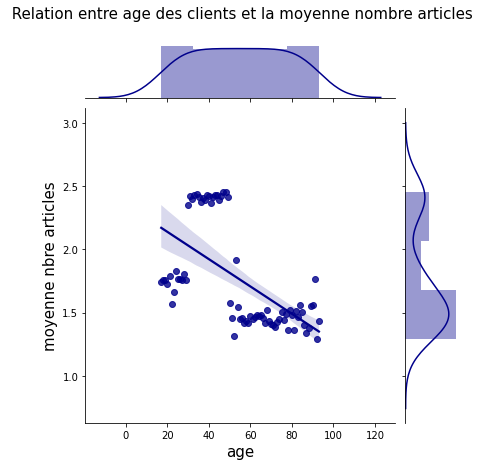

In [236]:
# Relation entre age des clients et la moyenne nombre articles
sns.jointplot(x='age', y='moyenne nbre articles',color='darkblue', data= df5, kind='reg')
plt.xlabel('age', size=15)
plt.ylabel('moyenne nbre articles', size=15)
plt.title(" Relation entre age des clients et la moyenne nombre articles", y=3000, pad= 90, size=15)


In [237]:
# Coefficient corrélation (la force de relation entre x et y est de 58% et sens négatif)
df5.corr()

,age,moyenne nbre articles
age,1.000000,-0.589024
moyenne nbre articles,-0.589024,1.000000


In [238]:
# Coefficient corrélation (kendall, spearman)
print(df5['age'].corr(df5['moyenne nbre articles'], method='kendall'))
print(df5['age'].corr(df5['moyenne nbre articles'], method='spearman'))

-0.378673957621326
-0.650375939849624


In [239]:
# R carré (qualité prédictive de la régréssion linéaire )
(-0.589024)**2

0.346949272576

In [240]:
#  Teste pearson si deux échantillons ont une relation linéaire.
#H0: les deux échantillons sont indépendants.
#H1: il existe une dépendance entre les échantillons.

from scipy.stats import pearsonr
data1 = df5['age'].values
data2 = df5['moyenne nbre articles'].values
stat, p = pearsonr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('probablement indépendant ')
else:

    print('Probablement dépendant ')

stat=-0.589, p=0.000
Probablement dépendant 


In [241]:
#Teste si un échantillon de données(age) a une distribution gaussienne avec shapiro
#H0: l'échantillon a une distribution gaussienne.
#H1: l'échantillon n'a pas de distribution gaussienne.

from scipy.stats import shapiro
import scipy.stats
data = df5['moyenne nbre articles'].values
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("la distribution age est probalemement gaussien")
else:
    print("la distribution age n'est probalemement pas gaussien")

stat=0.781, p=0.000
la distribution age n'est probalemement pas gaussien


In [242]:
print("Conclusion: Il y a une corrélation négative entre la moyenne nbre articles et l'ages des clients")

Conclusion: Il y a une corrélation négative entre la moyenne nbre articles et l'ages des clients


# Y a-t-il une corrélation entre l'âge des clients et : Les catégories de produits achetés.

Text(0.5, 1.0, 'Les 3 populations sont différentes ')

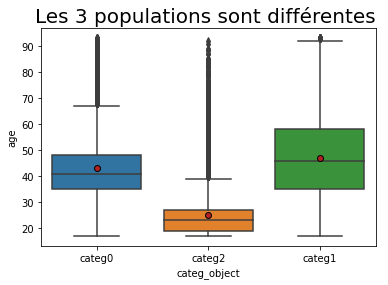

In [243]:
# Utilisation du sous-échantillon (sans les 4 clients outliers atypiques)
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
sns.boxplot(x="categ_object", y="age", showmeans=True, meanprops=meanprops,
            data=data_final2)
plt.title("Les 3 populations sont différentes ", size=20)

In [244]:
#Projections age et categ
df = data_final2[['age', 'categ_object']]
df.head()

,age,categ_object
0,44,categ0
1,22,categ2
2,42,categ1
3,58,categ0
4,41,categ0


In [245]:
# Restriction sur la categorie 0 
categ0 = df[df['categ_object']=='categ0']
categ0.head()

,age,categ_object
0,44,categ0
3,58,categ0
4,41,categ0
5,39,categ0
6,59,categ0


In [246]:
# Restriction sur la categorie 1
categ1 = df[df['categ_object']=='categ1']
categ1.head()

,age,categ_object
2,42,categ1
15,51,categ1
16,34,categ1
20,51,categ1
23,55,categ1


In [247]:
# Restriction sur la categorie 2
categ2 = df[df['categ_object']=='categ2']
categ2.head()

,age,categ_object
1,22,categ2
27,56,categ2
71,25,categ2
106,22,categ2
127,27,categ2


In [248]:
#Les valeurs uniques de colonne categ_object
grps = pd.unique(df['categ_object'].values)
grps

# création dictionnaire entre categ_object et age
d_data = {grp:df['age'][df.categ_object == grp].values for grp in grps}
d_data

{'categ0': array([44, 58, 41, ..., 71, 30, 53]),
 'categ2': array([22, 56, 25, ..., 17, 20, 27]),
 'categ1': array([42, 51, 34, ..., 53, 35, 32])}

In [249]:
#Test non paramètrique kruskall

#H0 : toutes les distributions d'échantillons sont égales.
#H1 : une ou plusieurs distributions d'échantillon ne sont pas égales.


from scipy import stats
x = categ0['age'].values
y = categ1['age'].values
z = categ2['age'].values
stats.kruskal(x, y, z)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('les 3 populations sont significativements les memes')
else:
    print('les 3 populations sont significativements différentes')
    


stat=0.781, p=0.000
les 3 populations sont significativements différentes


In [250]:
#Teste anova si les moyennes de deux échantillons indépendants ou plus sont significativement différentes.
#H0: les moyennes des échantillons sont égales.
#H1: une ou plusieurs des moyennes des échantillons sont inégales.

stat, p = stats.f_oneway(d_data['categ0'], d_data['categ1'],  d_data['categ2'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('les 3 populations sont significativements les memes')
else:
    print('les 3 populations sont significativements différentes')
    

stat=19992.374, p=0.000
les 3 populations sont significativements différentes


In [251]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('age ~ categ_object', data=data_final2).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
categ_object,6.759386e+06,2.0,19992.37421,0.0
Residual,5.300518e+07,313549.0,NaN,NaN


In [252]:

def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
categ_object,6.759386e+06,2.0,3.379693e+06,19992.37421,0.0,0.1131,0.113094
Residual,5.300518e+07,313549.0,1.690491e+02,NaN,NaN,NaN,NaN


In [253]:
#teste pingouin pour trouver  eta carré
import pingouin as pg
aov = pg.anova(data=df, dv='age', between='categ_object', detailed=True, effsize='n2')
print(aov)

         Source            SS      DF            MS            F  p-unc  \
0  categ_object  6.759386e+06       2  3.379693e+06  19992.37421    0.0   
1        Within  5.300518e+07  313549  1.690491e+02          NaN    NaN   

       n2  
0  0.1131  
1     NaN  


In [254]:
# Calcule de eta carré 
aov['n2'][0]
#une corrélation de 0.12 sur echelle de 0 à 1

0.11310023045719024

In [255]:
print("Conclusion: Il y a une corrélation entre l'age des clients et les catégories de produits achetés")

Conclusion: Il y a une corrélation entre l'age des clients et les catégories de produits achetés
